In [28]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import dijet
import random
from IPython.display import display, Math
from tqdm import tqdm

# setup plotting
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["axes.labelsize"] = 16  
plt.rcParams["xtick.labelsize"] = 14  
plt.rcParams["ytick.labelsize"] = 14
plt.rcParams["axes.titlesize"] = 18  
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"
%config InlineBackend.figure_format = 'retina'

In [29]:
# calculate bands for correlations

# files = ['oam3_range30', 'oam3_range10', 'oam1_range10']
files = ['oam3_range10', 'oam3_range10_xi04']
data = {}
for file in files:
    data[file] = np.load(f'data/dsa_corr_{file}.npy', allow_pickle=True).item()

fit = '+pp(constrained)'
confid = 68

for file in data:
    for irep in range(len(data[file][fit])):
        data[file][fit][irep]['<cos(phi_Dp + phi_kp)>'] = data[file][fit][irep]['<cos(phi_Dp)cos(phi_kp)>'] - data[file][fit][irep]['<sin(phi_Dp)sin(phi_kp)>']
        data[file][fit][irep]['<cos(phi_Dp - phi_kp)>'] = data[file][fit][irep]['<cos(phi_Dp)cos(phi_kp)>'] + data[file][fit][irep]['<sin(phi_Dp)sin(phi_kp)>']
    

bands = {}

for file in data:
    bands[file] = {}
    for obj in ['lower', 'upper', 'mean']:
        bands[file][obj] = {}

    for corr in ['<1>', '<cos(phi_Dp)>', '<cos(phi_Dp)cos(phi_kp)>', '<sin(phi_Dp)sin(phi_kp)>', '<cos(phi_Dp + phi_kp)>', '<cos(phi_Dp - phi_kp)>']:
        corr_reps = [rep[corr] for rep in data[file][fit]]
        bands[file]['lower'][corr] = np.percentile(corr_reps, 0.5*(100-confid), axis=0, method='inverted_cdf')
        bands[file]['upper'][corr] = np.percentile(corr_reps, 100 - 0.5*(100-confid), axis=0, method='inverted_cdf')
        bands[file]['mean'][corr] = np.mean(corr_reps, axis=0)


lumi = 100
all_error = 2*np.sqrt(1/(2*lumi*np.array(data[file][fit][0]['denom'])))
tt_error = 2*np.sqrt(2.0/(2*lumi*np.array(data[file][fit][0]['denom'])))
lt_error = 2*np.sqrt(2.0/(2*lumi*np.array(data[file][fit][0]['denom'])))

# print(tt_error)

# get kinematics + make labels

space = data[files[0]]['space']
pT_values = data[files[0]]['pT values']
roots = data[files[0]]['roots']

space_labels = {
    'y' : r'y',
    'z' : r'z',
    'Q2': r'Q^2',
    't' : r't',
    'phi_Dp': r'\phi_{\Delta p}',
    'phi_kp': r'\phi_{k p}'
}

var_labels = [r'p_{\perp}']
for key in space:
    if isinstance(space[key], list): continue
    var_labels.append(space_labels[key])

num_label = '{}' if len(var_labels)==1 else fr'{len(var_labels)}'
den_label = ''.join(['d' + v for v in var_labels])

info_text = fr'$\sqrt{{s}} = {roots}\,\, \mathrm{{GeV}}$' + '\n'
for var in space:
    if isinstance(space[var], list): 
        low = space[var][0]
        high = space[var][1]
        if var == 'Q2':
            # info_text += fr'$Q^2 \, \in \,[{round(low,1)}, \, {round(high,1)}]\, \mathrm{{GeV^2}}$' + '\n'
            info_text += fr'$\overline{{Q}}_0 \, = 2 \, \mathrm{{GeV}}$' + '\n'
            # pass
        elif var == 'y':
            info_text += fr'$y \, \in \, [{round(low,3)}, \, {round(high,3)}]$' + '\n'
        elif var == 'z':
            info_text += fr'$z \, \in \, [{round(low,2)}, \, {round(high,2)}]$' + '\n'
        elif var == 't':
            info_text += fr'$t \, \in \,  [{round(low,2)}, \, {round(high,2)}]\, \mathrm{{GeV}}^2$'
    else:
        value = space[var]
        if var == 'Q2':
            info_text += fr'$Q^2 \, = \,{value}\, \mathrm{{GeV^2}}$' + '\n'
        elif var == 'y':
            info_text += fr'$y \, = \, {value}$' + '\n'
        elif var == 'z':
            info_text += fr'$z \, = \, {value}$' + '\n'
        elif var == 't':
            info_text += fr'$t \, = \,  {value}\, \mathrm{{GeV}}^2$'


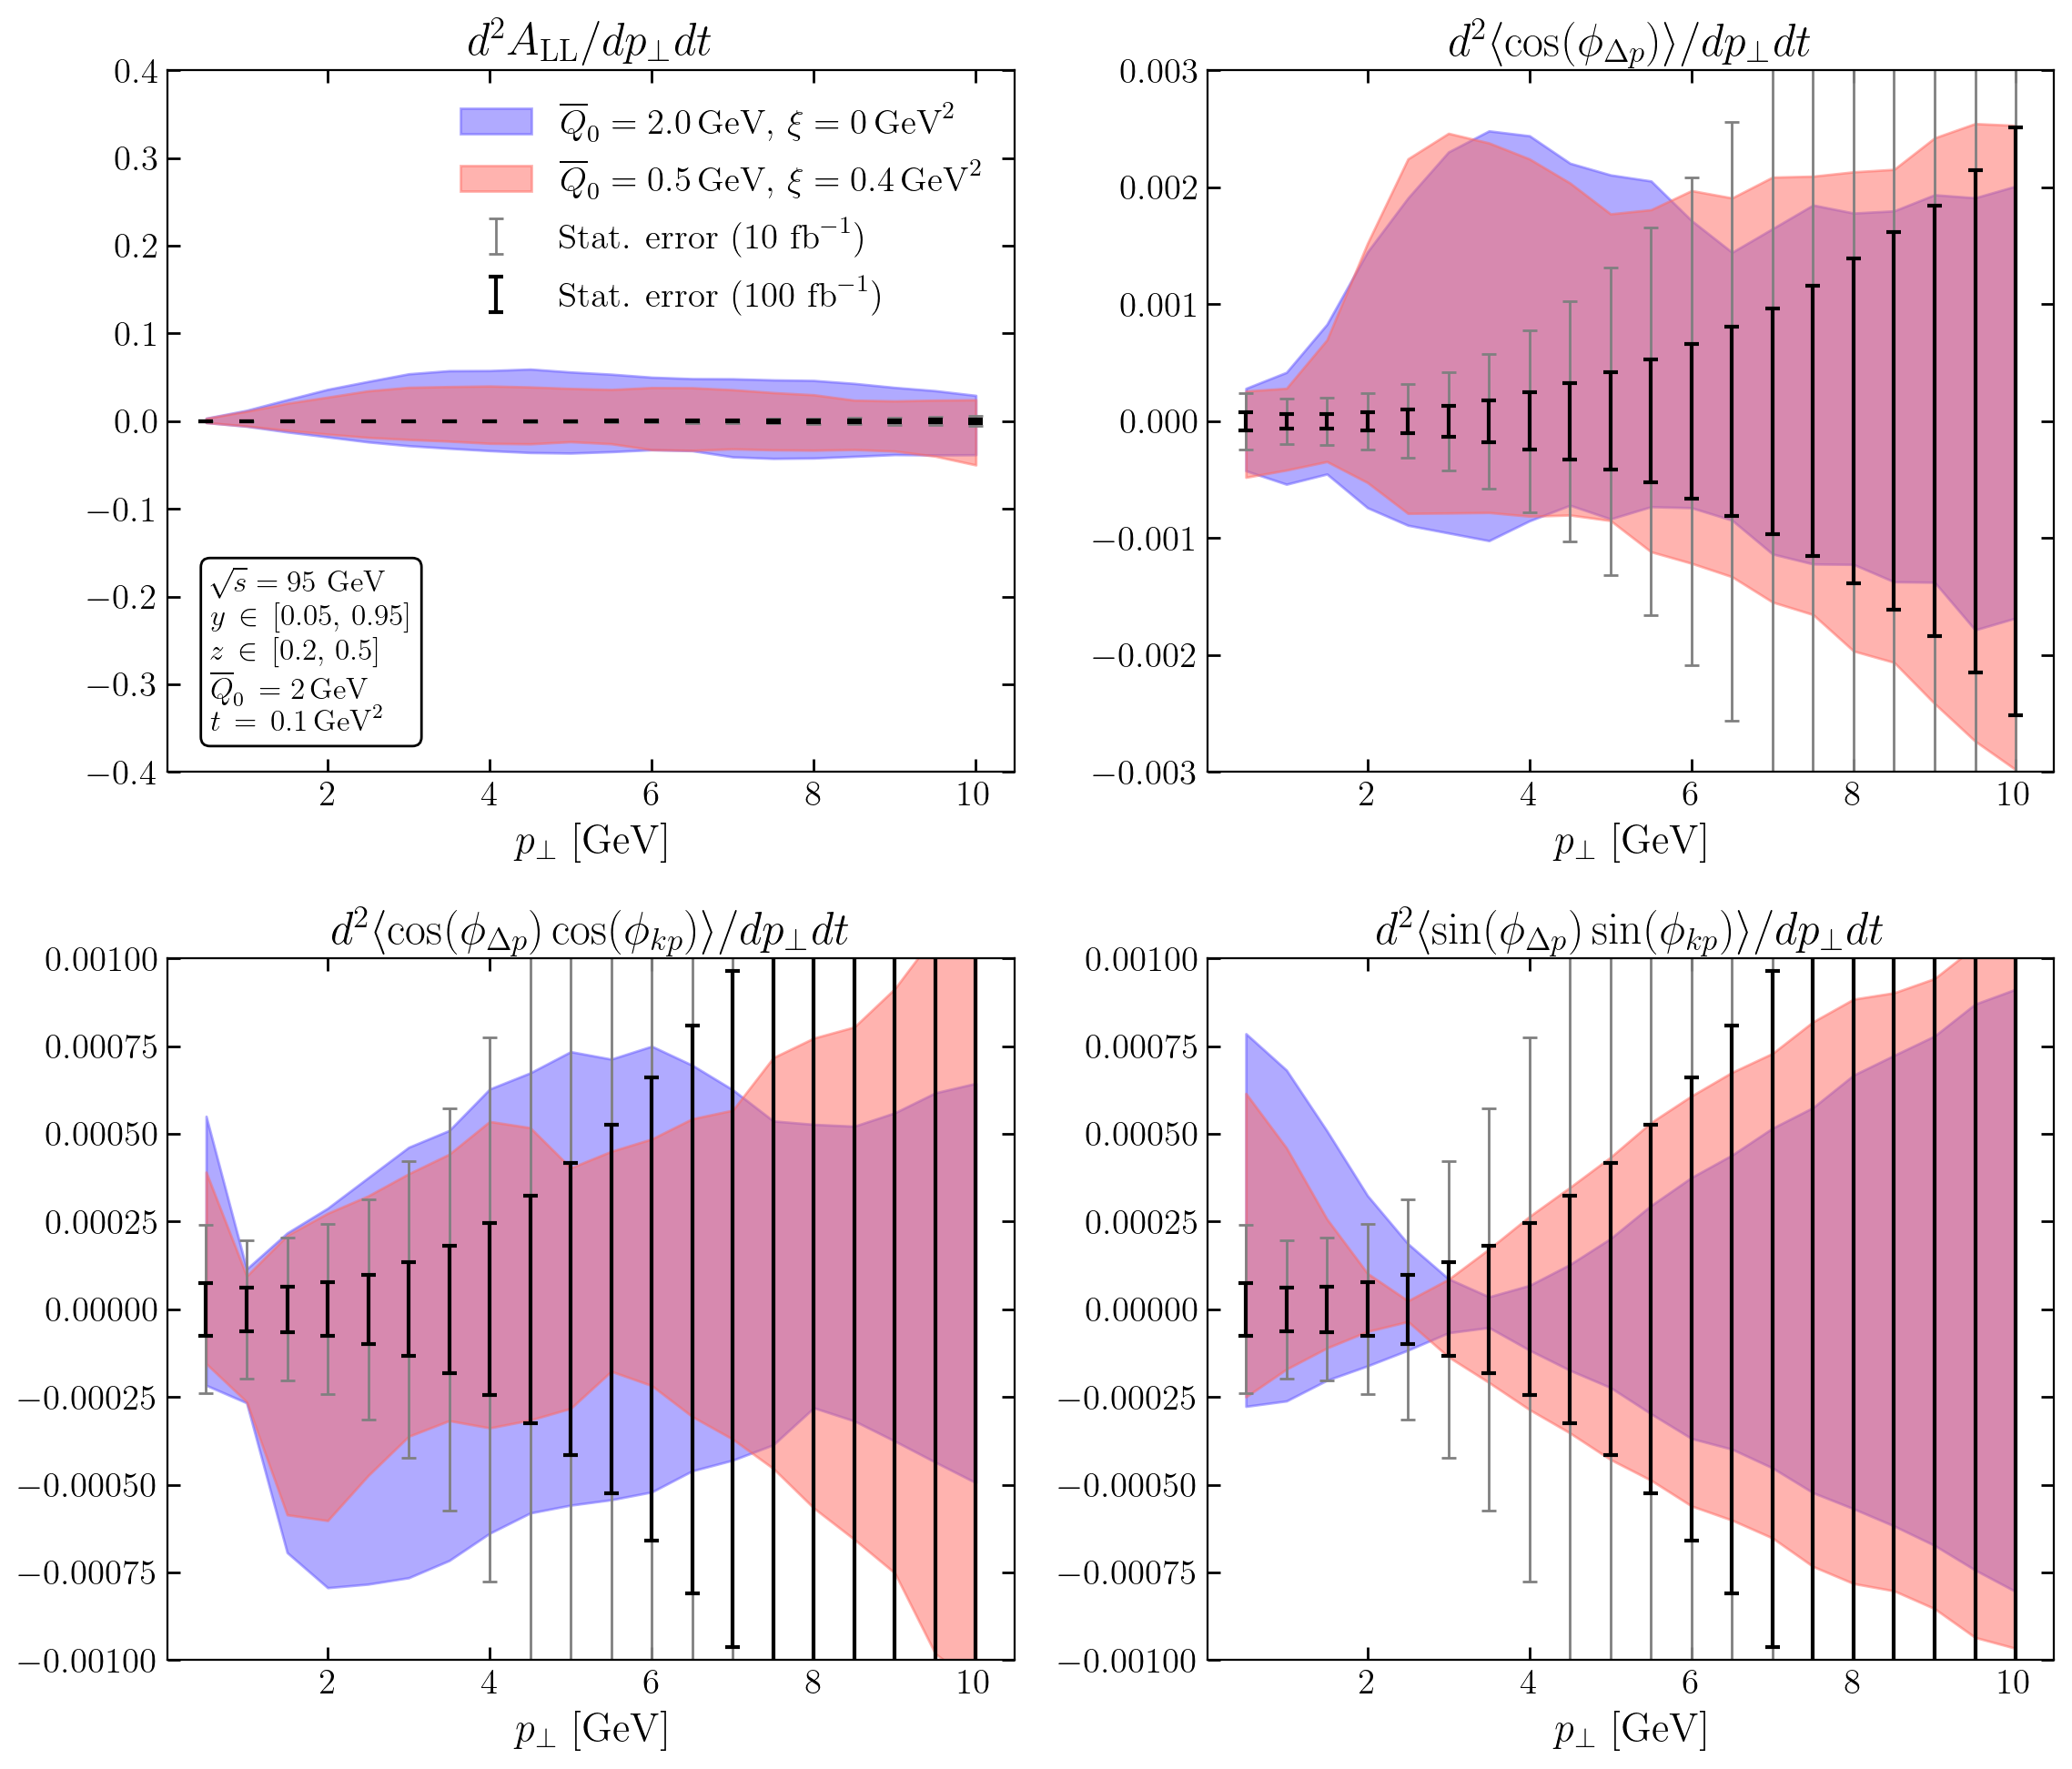

In [41]:
# plot azimuthal correlations
asp_ratio = 3.5/3
psize = 5

nrows, ncols = 2, 2
fig, ax = plt.subplots(nrows, ncols, figsize=(asp_ratio*psize*ncols, psize*nrows))
axs = [ax[irow, icol] for irow in range(nrows) for icol in range(ncols)]

plot_bands = True
alt_defs = False
plot_stat_errors = True

# colors = ['green', 'blue', 'red']
# colors = ['#FF6961', '#6257ff', '#51c46f']
colors = ['#6257ff', '#FF6961']

# labels = [r'$\Big|\int \displaylimits^{0.1}_{10^{-5}} dx\, L(x) \Big| < 3, \,\,|p_I| < 30$',
#           r'$\Big|\int \displaylimits^{0.1}_{10^{-5}} dx\, L(x) \Big| < 3,\,\, |p_I| < 10$', 
#           r'$\Big|\int \displaylimits^{0.1}_{10^{-5}} dx\, L(x) \Big| < 1,\,\,  |p_I| < 10$']
labels = [r'$\overline{Q}_0 = 2.0 \, \mathrm{GeV}, \, \xi = 0 \, \mathrm{GeV}^2$', r'$\overline{Q}_0 = 0.5 \, \mathrm{GeV}, \, \xi = 0.4 \, \mathrm{GeV}^2$']

corrs = ['<1>', '<cos(phi_Dp)>', '<cos(phi_Dp)cos(phi_kp)>', '<sin(phi_Dp)sin(phi_kp)>']
if alt_defs: 
    corrs = ['<1>', '<cos(phi_Dp)>', '<cos(phi_Dp + phi_kp)>', '<cos(phi_Dp - phi_kp)>']

    

for ifile, file in enumerate(data):
    # if file != 'oam3_range10': continue
    for icorr, corr in enumerate(corrs):
        if plot_bands:
            axs[icorr].fill_between(pT_values, bands[file]['lower'][corr], bands[file]['upper'][corr], color=colors[ifile], alpha=0.5, label=labels[ifile])
        
        else:
            for irep, rep in enumerate(data[file][fit]):
                if irep > 101: 
                    continue
                if irep == 0:
                    axs[icorr].plot(pT_values, np.array(rep[corr]), alpha=0.2, color=colors[ifile], label=labels[ifile], zorder=1)
                else: 
                    axs[icorr].plot(pT_values, np.array(rep[corr]), alpha=0.2, color=colors[ifile], zorder=1)


errors = [all_error, tt_error, tt_error, tt_error]
if plot_stat_errors:
    for icorr, corr in enumerate(corrs):
        if plot_bands:
            axs[icorr].errorbar(
                    pT_values, np.zeros(all_error.shape), yerr=np.sqrt(10)*errors[icorr], fmt='o',
                    capsize=3, elinewidth=1, capthick=1, color='gray', markersize=0, 
                    label=rf'Stat. error ({round(lumi/10)} $\mathrm{{fb}}^{{-1}}$)'
            )
            axs[icorr].errorbar(
                    pT_values, np.zeros(all_error.shape), yerr=errors[icorr], fmt='o',
                    capsize=3, elinewidth=1.5, capthick=1.5, color='black', markersize=0, 
                    label=rf'Stat. error ({lumi} $\mathrm{{fb}}^{{-1}}$)'
            )
        else:
            axs[icorr].fill_between(
                    pT_values, np.zeros(all_error.shape) - np.sqrt(10)*errors[icorr], np.zeros(all_error.shape) + np.sqrt(10)*errors[icorr],
                    color='gray', alpha=0.3,
                    label=rf'Stat. error ({round(lumi/10)} $\mathrm{{fb}}^{{-1}}$)',
                    zorder=2
            )
            axs[icorr].plot(
                    pT_values, np.zeros(all_error.shape) - np.sqrt(10)*errors[icorr],
                    color='black', alpha=0.3,
                    zorder=2
            )
            axs[icorr].plot(
                    pT_values, np.zeros(all_error.shape) + np.sqrt(10)*errors[icorr],
                    color='black', alpha=0.3,
                    zorder=2
            )
            axs[icorr].fill_between(
                    pT_values, np.zeros(all_error.shape) - errors[icorr], np.zeros(all_error.shape) + errors[icorr],
                    color='black', alpha=0.3,
                    label=rf'Stat. error ({lumi} $\mathrm{{fb}}^{{-1}}$)',
                    zorder=2
            )
                    



# axs[0].axhline(y=1, color='grey', linestyle=':')
# axs[0].axhline(y=-1, color='grey', linestyle=':')
# axs[0].axhline(y=0, color='lightgray', linestyle='--')
axs[0].set_xlabel(r'$p_{\perp}$ [GeV]')
axs[0].set_title(fr'$ d^{num_label} A_{{\mathrm{{LL}}}} / {den_label} $')
axs[0].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)
axs[0].legend(frameon=False, fontsize=14)
axs[0].text(
    0.05, 0.05, info_text, 
    transform=axs[0].transAxes,
    ha='left', va='bottom', 
    fontsize=12, wrap=True, 
    bbox=dict(boxstyle='round', facecolor='white', alpha=1.0, edgecolor='black')
)
# axs[0].semilogy()
axs[0].set_ylim([-0.4, 0.4])

# axs[1].axhline(y=0, color='lightgray', linestyle='--')
axs[1].set_xlabel(r'$p_\perp$ [GeV]')
axs[1].set_title(fr'$ d^{num_label} \langle \cos(\phi_{{\Delta p}}) \rangle / {den_label} $')
axs[1].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)
# axs[1].legend(frameon=False)
axs[1].set_ylim([-0.003, 0.003])
# axs[1].semilogy()


# axs[2].axhline(y=0, color='lightgray', linestyle='--')
axs[2].set_xlabel(r'$p_{\perp}$ [GeV]')
if alt_defs:
    axs[2].set_title(fr'$ d^{num_label}  \langle \cos(\phi_{{\Delta p}} + \phi_{{k p}}) \rangle / {den_label} $')
else: 
    axs[2].set_title(fr'$ d^{num_label}  \langle \cos(\phi_{{\Delta p}}) \cos(\phi_{{k p}}) \rangle / {den_label} $')
axs[2].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)
# axs[2].legend(frameon=False)
axs[2].set_ylim([-0.001, 0.001])
# axs[2].semilogy()

# axs[3].axhline(y=0, color='lightgray', linestyle='--')
axs[3].set_xlabel(r'$p_{\perp}$ [GeV]')
if alt_defs:
    axs[3].set_title(fr'$ d^{num_label} \langle \cos(\phi_{{\Delta p}} - \phi_{{k p}})  \rangle / {den_label} $')
else:
    axs[3].set_title(fr'$ d^{num_label} \langle \sin(\phi_{{\Delta p}}) \sin(\phi_{{k p}})  \rangle / {den_label} $')
axs[3].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)
# axs[3].legend(frameon=False)
axs[3].set_ylim([-0.001, 0.001])
# axs[3].semilogy()
# axs[1].legend()

plt.tight_layout()
plt.show()

if plot_bands:
    fig.savefig('plots/dsa_band_lowQ2.pdf', dpi=400, bbox_inches="tight")
else:
    fig.savefig('plots/dsa_lines_constraints.pdf', dpi=400, bbox_inches="tight")
